In [1]:
import numpy as np
import glob
import pickle
import os

In [2]:
import matplotlib
import colorsys

def random_label_cmap(n=2**16, h = (0,1), l = (.4,1), s =(.2,.8)):

    h,l,s = np.random.uniform(*h,n), np.random.uniform(*l,n), np.random.uniform(*s,n)
    cols = np.stack([colorsys.hls_to_rgb(_h,_l,_s) for _h,_l,_s in zip(h,l,s)],axis=0)
    cols[0] = 0

    random_label_cmap = matplotlib.colors.ListedColormap(cols)

    return random_label_cmap

lbl_cmap = random_label_cmap()

In [3]:
def load_data_from_pickles(cellpose_file='./Cellpose/CellPose_predictions.pkl', 
                           stardist_file='./StarDist/StarDist_predictions.pkl'):

    # Load CellPose predictions
    with open(cellpose_file, 'rb') as file:
        cellpose_predictions = pickle.load(file)
    masks_cellpose = cellpose_predictions['masks']
    images_cellpose = cellpose_predictions['images']

    # Load StarDist predictions
    with open(stardist_file, 'rb') as file:
        stardist_predictions = pickle.load(file)
    masks_stardist = stardist_predictions['masks']
    images_stardist = stardist_predictions['images']
        
    return (images_stardist, images_cellpose), (masks_stardist, masks_cellpose)

In [4]:
(images_stardist, images_cellpose), (masks_stardist, masks_cellpose) = load_data_from_pickles()

In [5]:
# Check if the number of images in both lists is the same
if len(images_stardist) != len(images_cellpose):
    raise ValueError("The two lists have a different number of images.")

for img1, img2 in zip(images_stardist, images_cellpose):
    if not np.array_equal(img1, img2):
        raise ValueError("The images in the lists are not the same.")

In [6]:
if len(masks_stardist) != len(masks_cellpose):
    raise ValueError ('Check images/masks data')

In [7]:
def compute_metrics(mask_a, mask_b):

    # Convert to binary masks
    mask_a = (mask_a > 0).astype(np.uint8)
    mask_b = (mask_b > 0).astype(np.uint8)

    intersection = np.logical_and(mask_a, mask_b)
    union = np.logical_or(mask_a, mask_b)
    
    sum_mask_a = np.sum(mask_a)
    sum_mask_b = np.sum(mask_b)
    
    # IoU
    iou = np.sum(intersection) / np.sum(union)
    
    # Dice Coefficient
    dice = 2. * np.sum(intersection) / (sum_mask_a + sum_mask_b)
    
    # Pixel Accuracy
    pixel_acc = np.sum(mask_a == mask_b) / mask_a.size
        
    return round(iou, 3), round(dice, 3), round(pixel_acc, 3)

In [8]:
def evaluate(mask_index, image_a, image_b, mask_a, mask_b):

    iou, dice, pixel_acc = compute_metrics(mask_a, mask_b)
        
    return {'IoU': iou, 'Dice Coefficient': dice, 'Pixel Accuracy': pixel_acc}

In [9]:
for mask_index in range(len(masks_stardist)):

    metrics = evaluate(mask_index, 
                       images_stardist[mask_index], 
                       images_cellpose[mask_index],
                       masks_stardist[mask_index], 
                       masks_cellpose[mask_index])

    print(metrics)

{'IoU': 0.793, 'Dice Coefficient': 0.885, 'Pixel Accuracy': 0.953}
{'IoU': 0.802, 'Dice Coefficient': 0.89, 'Pixel Accuracy': 0.944}
{'IoU': 0.79, 'Dice Coefficient': 0.883, 'Pixel Accuracy': 0.995}
{'IoU': 0.877, 'Dice Coefficient': 0.934, 'Pixel Accuracy': 0.997}
{'IoU': 0.874, 'Dice Coefficient': 0.933, 'Pixel Accuracy': 0.997}
{'IoU': 0.892, 'Dice Coefficient': 0.943, 'Pixel Accuracy': 0.998}
{'IoU': 0.856, 'Dice Coefficient': 0.922, 'Pixel Accuracy': 0.997}
{'IoU': 0.799, 'Dice Coefficient': 0.888, 'Pixel Accuracy': 0.995}
{'IoU': 0.797, 'Dice Coefficient': 0.887, 'Pixel Accuracy': 0.995}
{'IoU': 0.875, 'Dice Coefficient': 0.933, 'Pixel Accuracy': 0.997}
{'IoU': 0.838, 'Dice Coefficient': 0.912, 'Pixel Accuracy': 0.997}
{'IoU': 0.786, 'Dice Coefficient': 0.88, 'Pixel Accuracy': 0.944}
{'IoU': 0.787, 'Dice Coefficient': 0.881, 'Pixel Accuracy': 0.996}
{'IoU': 0.803, 'Dice Coefficient': 0.891, 'Pixel Accuracy': 0.944}
{'IoU': 0.797, 'Dice Coefficient': 0.887, 'Pixel Accuracy': 0.941

In [10]:
def plot_images_and_masks(images, masks1, masks2, num_images=6, lbl_cmap=None):
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    
    """
    Plots randomly selected images along with their corresponding masks from two different methods.
    
    :param images: List or array of images
    :param masks1: List or array of masks from the first method (e.g., StarDist)
    :param masks2: List or array of masks from the second method (e.g., Cellpose)
    :param num_images: Number of images to randomly select and plot
    :param lbl_cmap: Matplotlib colormap for displaying the masks
    """
    # Ensure that the images list is long enough
    if len(images) < 20:
        raise ValueError("The images list must contain at least 20 images.")
    
    # Select 3 random indices from images 1-10 and 3 from images 11-20
    indices_1_10 = np.random.choice(range(10), 3, replace=False)
    indices_11_20 = np.random.choice(range(10, 20), 3, replace=False)
    selected_indices = np.concatenate((indices_1_10, indices_11_20))

    # Define the figure size and grid layout
    fig = plt.figure(figsize=(25, 3 * num_images))  # Adjusted width for 5 columns
    gs = gridspec.GridSpec(num_images, 5, height_ratios=[1]*num_images)  # 5 columns

    # Iterate through the selected indices to create plots
    for i, idx in enumerate(selected_indices):

        # Original Image
        ax0 = fig.add_subplot(gs[i, 0])
        ax0.imshow(images[idx], cmap='gray')
        ax0.set_title(f'Image #{idx + 1}')
        ax0.set_xticks([])
        ax0.set_yticks([])

        # StarDist Mask
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.imshow(masks1[idx], cmap=lbl_cmap, alpha=1)
        ax1.set_title(f'StarDist Mask (Image #{idx + 1})')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # StarDist Mask Overlay
        ax2 = fig.add_subplot(gs[i, 2])
        mask_float1 = np.float32(masks1[idx])
        mask_float1[mask_float1 == 0] = np.nan
        ax2.imshow(images[idx], cmap='gray', alpha=1)
        ax2.imshow(mask_float1, cmap=lbl_cmap, alpha=0.5)
        ax2.set_title(f'StarDist Mask Overlay (Image #{idx + 1})')
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Cellpose Mask
        ax3 = fig.add_subplot(gs[i, 3])
        ax3.imshow(masks2[idx], cmap=lbl_cmap, alpha=1)
        ax3.set_title(f'Cellpose Mask (Image #{idx + 1})')
        ax3.set_xticks([])
        ax3.set_yticks([])

        # Cellpose Mask Overlay
        ax4 = fig.add_subplot(gs[i, 4])
        mask_float2 = np.float32(masks2[idx])
        mask_float2[mask_float2 == 0] = np.nan
        ax4.imshow(images[idx], cmap='gray', alpha=1)
        ax4.imshow(mask_float2, cmap=lbl_cmap, alpha=0.5)
        ax4.set_title(f'Cellpose Mask Overlay (Image #{idx + 1})')
        ax4.set_xticks([])
        ax4.set_yticks([])

    # Adjust spacing between plots
    plt.subplots_adjust(hspace=0.15)  # Adjust as needed

    # Save the figure
    filename = 'Comparison.tif'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename, dpi=300, format='tif', bbox_inches='tight')

    # Display the plots
    plt.show()

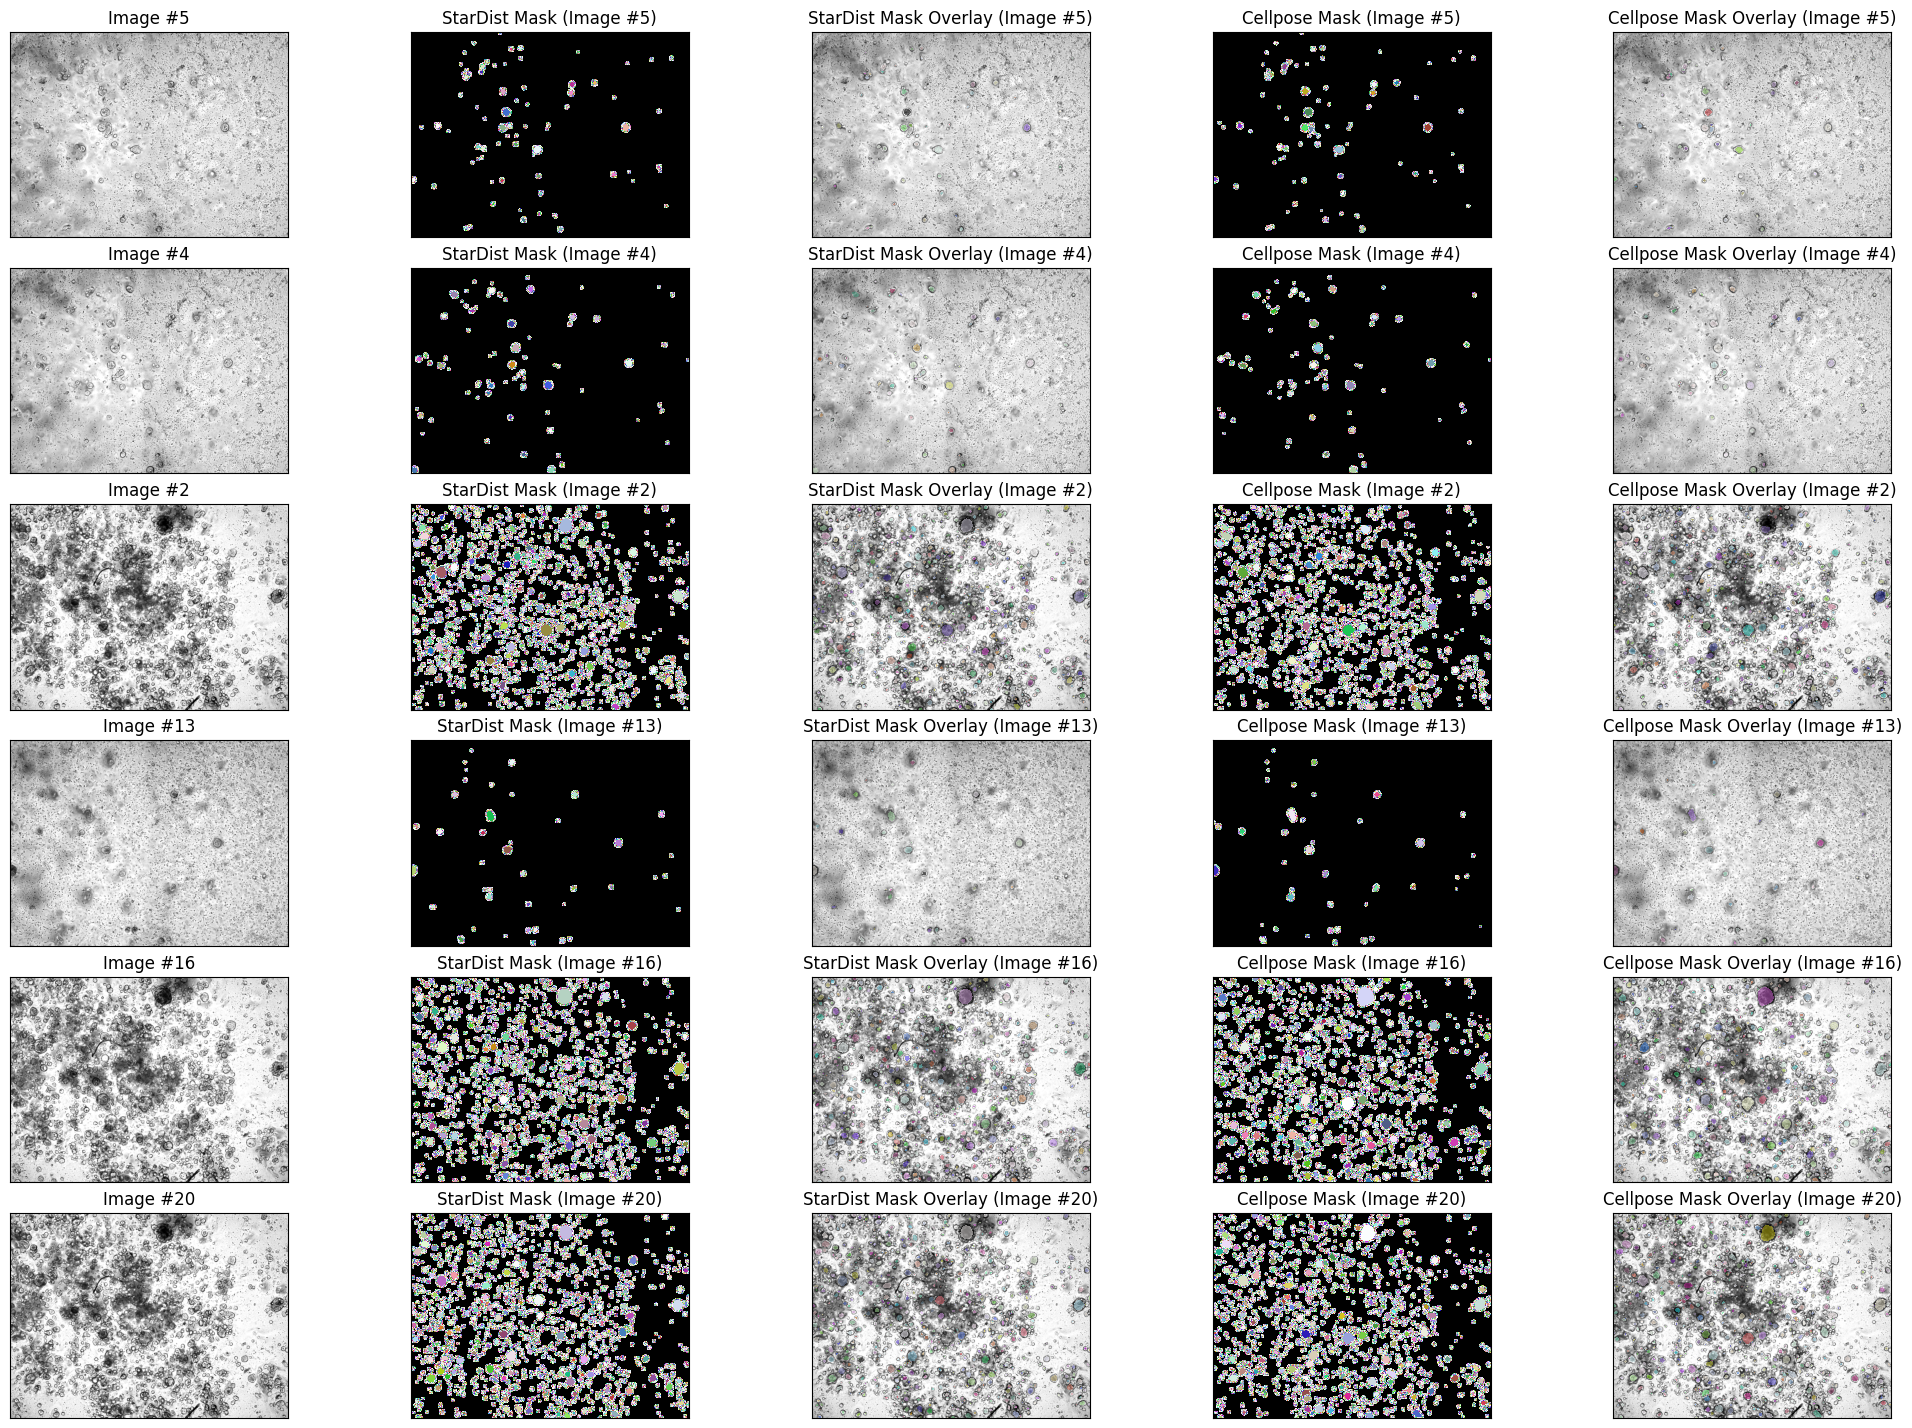

In [11]:
# Plot the images and masks
plot_images_and_masks(images_stardist, masks_stardist, masks_cellpose, lbl_cmap=lbl_cmap)